## 1. Configuração e Carregamento dos Dados

In [1]:
# Imports essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb

# Configurações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

In [2]:
df = pd.read_csv('../data/dataset_modelagem.csv')
df['date'] = pd.to_datetime(df['date'])

## 2. Correlação

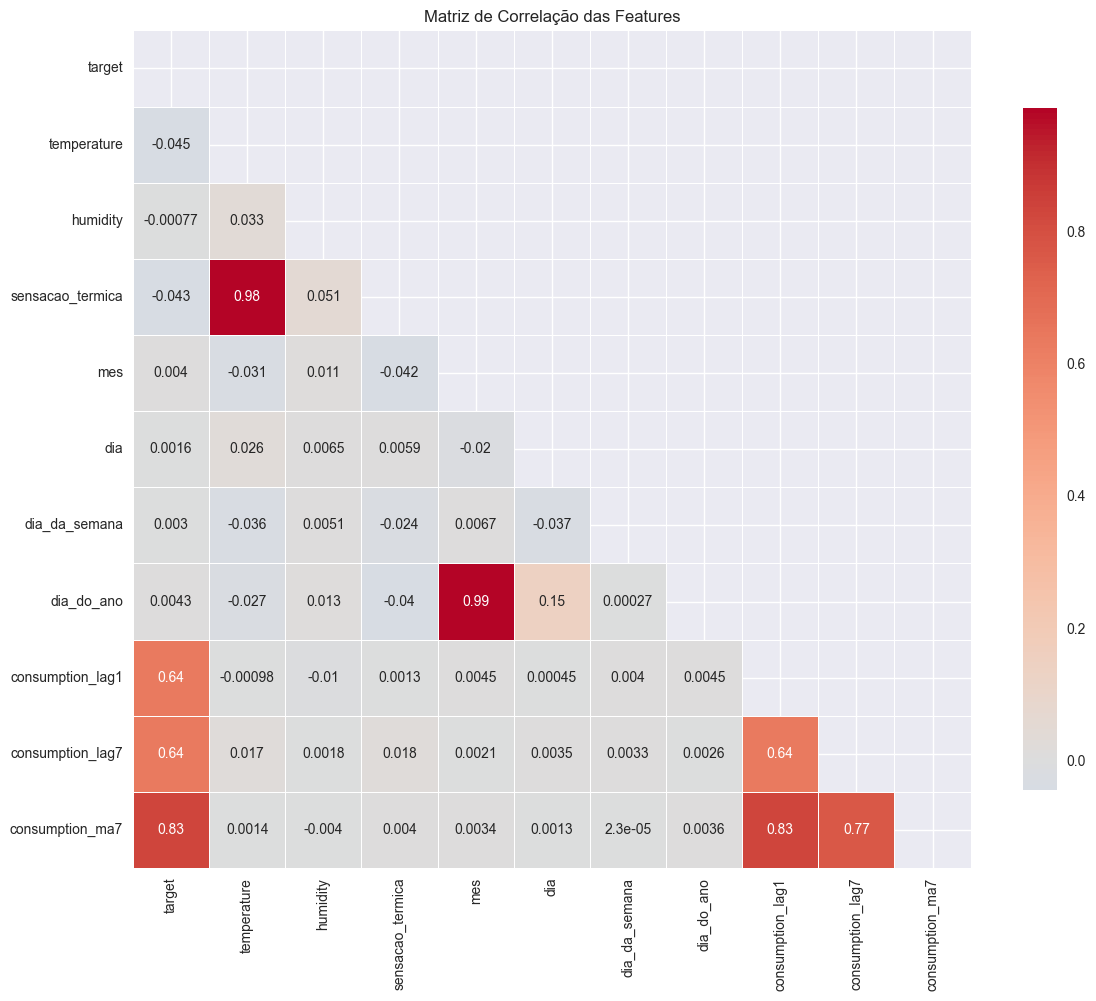

consumption_ma7     0.830291
consumption_lag1    0.638875
consumption_lag7    0.638314
temperature         0.045228
sensacao_termica    0.042740
dia_do_ano          0.004266
mes                 0.004048
dia_da_semana       0.002998
dia                 0.001613
humidity            0.000768
Name: target, dtype: float64


In [3]:
# Matriz de correlação
# Selecionando apenas features numéricas para correlação
numeric_features = ['target', 'temperature', 'humidity', 'sensacao_termica', 
                   'mes', 'dia', 'dia_da_semana', 'dia_do_ano',
                   'consumption_lag1', 'consumption_lag7', 'consumption_ma7']

correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação das Features')
plt.tight_layout()
plt.show()

# Top correlações com o target
target_corr = correlation_matrix['target'].abs().sort_values(ascending=False)
print(target_corr.drop('target').head(10))

## 3. Preparação dos Dados para Modelagem

In [4]:
# Preparação das features para modelagem
# Ordenando dados por cliente e data
df_sorted = df.sort_values(['client_id', 'date']).reset_index(drop=True)

# Codificando variável categórica 'region'
le_region = LabelEncoder()
df_sorted['region_encoded'] = le_region.fit_transform(df_sorted['region'])

# Definindo features para modelagem
feature_columns = [
    'temperature', 'humidity', 'sensacao_termica', 'region_encoded',
    'ano', 'mes', 'dia', 'dia_da_semana', 'dia_do_ano',
    'consumption_lag1', 'consumption_lag7', 'consumption_ma7'
]

# Separando features e target
X = df_sorted[feature_columns]
y = df_sorted['target']

In [5]:
# Calculando pontos de corte temporais
total_records = len(df_sorted)
train_size = int(0.7 * total_records)  
val_size = int(0.15 * total_records)  

# Índices de divisão
train_end = train_size
val_end = train_size + val_size

# Dividindo os dados
X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]
X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]
X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

# Datas correspondentes
train_dates = df_sorted['date'].iloc[:train_end]
val_dates = df_sorted['date'].iloc[train_end:val_end]
test_dates = df_sorted['date'].iloc[val_end:]

## 4. Treino, Teste e Validação

In [6]:
# Treinamento do Random Forest
# Modelo baseline
rf_baseline = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_baseline.fit(X_train, y_train)

# Predições
y_train_pred_rf = rf_baseline.predict(X_train)
y_val_pred_rf = rf_baseline.predict(X_val)
y_test_pred_rf = rf_baseline.predict(X_test)

# Métricas
def calcular_metricas(y_true, y_pred, tipo_base):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    # Evitando divisão por zero
    epsilon = 1e-10
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    
    print(tipo_base)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")
    print("")
    
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

rf_metrics_train = calcular_metricas(y_train, y_train_pred_rf, 'Treino')
rf_metrics_val = calcular_metricas(y_val, y_val_pred_rf, 'Validação')
rf_metrics_test = calcular_metricas(y_test, y_test_pred_rf, 'Teste')

Treino
RMSE: 0.7950
MAE: 0.6303
MAPE: 4.75%
R²: 0.9562

Validação
RMSE: 2.1187
MAE: 1.7050
MAPE: 12.89%
R²: 0.5826

Teste
RMSE: 2.0836
MAE: 1.6510
MAPE: 11.74%
R²: 0.6915



In [7]:
# Otimização de hiperparâmetros do Random Forest
# Grid de hiperparâmetros
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# TimeSeriesSplit para validação temporal
tscv = TimeSeriesSplit(n_splits=3)

# GridSearchCV
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"Parametros escolhidos: {rf_grid.best_params_}")
print(f"Score: {np.sqrt(-rf_grid.best_score_):.4f}")
print("")

# Modelo otimizado
rf_otimo = rf_grid.best_estimator_

# Predições com modelo otimizado
y_train_pred_rf_ot = rf_otimo.predict(X_train)
y_val_pred_rf_ot = rf_otimo.predict(X_val)
y_test_pred_rf_ot = rf_otimo.predict(X_test)

rf_metrics_train_ot = calcular_metricas(y_train, y_train_pred_rf_ot, "Treino")
rf_metrics_val = calcular_metricas(y_val, y_val_pred_rf_ot, "Validação")
rf_metrics_test = calcular_metricas(y_test, y_test_pred_rf_ot, "Teste")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Parametros escolhidos: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Score: 2.0854

Treino
RMSE: 1.7270
MAE: 1.3764
MAPE: 10.38%
R²: 0.7932

Validação
RMSE: 2.0827
MAE: 1.6767
MAPE: 12.69%
R²: 0.5967

Teste
RMSE: 2.0346
MAE: 1.6161
MAPE: 11.49%
R²: 0.7058



In [8]:
# Treinamento do XGBoost
# Modelo baseline
xgb_baseline = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_baseline.fit(X_train, y_train)

# Predições
y_train_pred_xgb = xgb_baseline.predict(X_train)
y_val_pred_xgb = xgb_baseline.predict(X_val)
y_test_pred_xgb = xgb_baseline.predict(X_test)

xgb_metrics_train = calcular_metricas(y_train, y_train_pred_xgb, "Treino")
xgb_metrics_val = calcular_metricas(y_val, y_val_pred_xgb, "Validação")
xgb_metrics_test = calcular_metricas(y_test, y_test_pred_xgb, "Teste")

Treino
RMSE: 1.4192
MAE: 1.1015
MAPE: 8.23%
R²: 0.8604

Validação
RMSE: 2.1596
MAE: 1.7269
MAPE: 13.05%
R²: 0.5664

Teste
RMSE: 2.1385
MAE: 1.7045
MAPE: 12.06%
R²: 0.6750



In [9]:
# Otimização de hiperparâmetros do XGBoost
# Grid de hiperparâmetros
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_grid = GridSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    param_grid_xgb,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

print(f"Parametros escolhidos: {xgb_grid.best_params_}")
print(f"Score: {np.sqrt(-xgb_grid.best_score_):.4f}")
print("")

# Modelo otimizado
xgb_otimo = xgb_grid.best_estimator_

# Predições com modelo otimizado
y_train_pred_xgb = xgb_otimo.predict(X_train)
y_val_pred_xgb = xgb_otimo.predict(X_val)
y_test_pred_xgb = xgb_otimo.predict(X_test)

xgb_metrics_train = calcular_metricas(y_train, y_train_pred_xgb, "Treino")
xgb_metrics_val = calcular_metricas(y_val, y_val_pred_xgb, "Validação")
xgb_metrics_test = calcular_metricas(y_test, y_test_pred_xgb, "Teste")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Parametros escolhidos: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Score: 2.0626

Treino
RMSE: 2.0071
MAE: 1.6018
MAPE: 12.12%
R²: 0.7207

Validação
RMSE: 2.0662
MAE: 1.6621
MAPE: 12.58%
R²: 0.6031

Teste
RMSE: 2.0148
MAE: 1.6063
MAPE: 11.42%
R²: 0.7115



In [10]:
# Definindo variáveis para análise comparativa
# Coletando modelos otimizados
rf_optimized = rf_otimo
xgb_optimized = xgb_otimo

# Calculando métricas finais para o conjunto de teste
rf_test_predictions = rf_optimized.predict(X_test)
xgb_test_predictions = xgb_optimized.predict(X_test)

rf_final_metrics = calcular_metricas(y_test, rf_test_predictions, "Random Forest Otimizado - Final")
xgb_final_metrics = calcular_metricas(y_test, xgb_test_predictions, "XGBoost Otimizado - Final")

# Comparando métricas para definir melhor modelo
models_comparison = {
    'RF Otimizado': {
        'RMSE_test': rf_final_metrics['RMSE'],
        'MAE_test': rf_final_metrics['MAE'],
        'MAPE_test': rf_final_metrics['MAPE'],
        'R2_test': rf_final_metrics['R2'],
        'predictions': rf_test_predictions
    },
    'XGB Otimizado': {
        'RMSE_test': xgb_final_metrics['RMSE'],
        'MAE_test': xgb_final_metrics['MAE'],
        'MAPE_test': xgb_final_metrics['MAPE'],
        'R2_test': xgb_final_metrics['R2'],
        'predictions': xgb_test_predictions
    }
}

# Melhor modelo baseado no RMSE de teste
best_rmse = min([model['RMSE_test'] for model in models_comparison.values()])
best_rmse_col = [name for name, model in models_comparison.items() if model['RMSE_test'] == best_rmse][0]
best_model = xgb_optimized if 'XGBoost' in best_rmse_col else rf_optimized
best_predictions = models_comparison[best_rmse_col]['predictions']

Random Forest Otimizado - Final
RMSE: 2.0346
MAE: 1.6161
MAPE: 11.49%
R²: 0.7058

XGBoost Otimizado - Final
RMSE: 2.0148
MAE: 1.6063
MAPE: 11.42%
R²: 0.7115



## 5. Análise de Feature Importance

In [11]:
# Análise de importância das features
feature_importance_final = pd.DataFrame({
    'feature': feature_columns,
    'importance': modelo_final.feature_importances_
}).sort_values('importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance_final)), feature_importance_final['importance'])
plt.yticks(range(len(feature_importance_final)), feature_importance_final['feature'])
plt.xlabel('Importância')
plt.title('Importância das Features')
plt.gca().invert_yaxis()

# Adicionando valores nas barras
for i, v in enumerate(feature_importance_final['importance']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

NameError: name 'modelo_final' is not defined

## 6. Visualizações e Análise de Resultados

In [ ]:
# Visualizações dos resultados do modelo otimizado
# Plot de predições vs valores reais
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plot - Predito vs Real
axes[0,0].scatter(y_test, y_test_pred_final, alpha=0.6, color='blue')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Consumo Real (kWh)')
axes[0,0].set_ylabel('Consumo Predito (kWh)')
axes[0,0].set_title('Predito vs Real - Modelo Final Otimizado')
axes[0,0].grid(True, alpha=0.3)

# Resíduos
residuals = y_test - y_test_pred_final
axes[0,1].scatter(y_test_pred_final, residuals, alpha=0.6, color='green')
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predições')
axes[0,1].set_ylabel('Resíduos')
axes[0,1].set_title('Análise de Resíduos')
axes[0,1].grid(True, alpha=0.3)

# Distribuição dos resíduos
axes[1,0].hist(residuals, bins=30, alpha=0.7, color='orange')
axes[1,0].set_xlabel('Resíduos')
axes[1,0].set_ylabel('Frequência')
axes[1,0].set_title('Distribuição dos Resíduos')
axes[1,0].grid(True, alpha=0.3)

# Série temporal das predições
sample_size = min(1000, len(y_test))  # Amostra para visualização
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
sample_dates = test_dates.iloc[sample_indices]
sample_real = y_test.iloc[sample_indices]
sample_pred = y_test_pred_final[sample_indices]

# Ordenando por data para visualização
sort_idx = np.argsort(sample_dates)
axes[1,1].plot(sample_dates.iloc[sort_idx], sample_real.iloc[sort_idx], 
               label='Real', alpha=0.7, color='blue')
axes[1,1].plot(sample_dates.iloc[sort_idx], sample_pred[sort_idx], 
               label='Predito', alpha=0.7, color='red')
axes[1,1].set_xlabel('Data')
axes[1,1].set_ylabel('Consumo (kWh)')
axes[1,1].set_title('Série Temporal - Modelo Otimizado')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas dos resíduos
print(f"- Média: {residuals.mean():.4f}")
print(f"- Desvio padrão: {residuals.std():.4f}")
print(f"- Min/Max: {residuals.min():.4f} / {residuals.max():.4f}")
